In [2]:
#socket pas sluiten bij 'q'
import cv2
import urllib.request
import requests
import numpy as np
import socket
from datetime import datetime
import pandas as pd
import time
import http.client
import os.path
from openpyxl import load_workbook


socket_ON = False
if(socket_ON):
    http_request_ON = False
    socket_ON = True
    filename = "output_socket.xlsx"
    sheet_name = 'Timestamps socket'
else:
    http_request_ON = True
    socket_ON = False
    filename = "output_http_memory.xlsx"
    sheet_name = 'Timestamps http'
cycles = 0
counter = 1



# Load the face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define the ESP32 Wrover's IP address and port number
url = 'http://192.168.0.179:81'
#print("FACE DETECTED ON:", ts_detect)
# Define the ESP32's IP address and port number
ip = "192.168.0.179"
port = 80
# Define the integer to send
message = 3

#init
arr_socket = np.array([])
arr_http = np.array([])
arr_read_vs_detect = np.array([])
av = pd.DataFrame({})
df = pd.DataFrame({})
ts_detect = 0
arr_data = np.array([])

# Open the video stream from the ESP32 Wrover
stream = urllib.request.urlopen(url)

cv2.namedWindow('Video Stream', cv2.WINDOW_NORMAL)

# Loop through the frames in the video stream, time stamp nog toevoegen begin read en face detected

while True:
    # Read the next frame from the video stream
    buffer = bytes()
    #set timestamp start reading
    dt = datetime.now()
    ts_data = datetime.timestamp(dt)
    while True:
        try:            
            buffer += stream.read(3000)
            #buffer += stream.read(10000)
        except http.client.IncompleteRead:
            print("IncompleteRead error occurred, retrying...")
            continue
    
        a = buffer.find(b'\xff\xd8')
        b = buffer.find(b'\xff\xd9')
        
        
        #print(a, b)
        if a != -1 and b != -1:
            break
        elif a != -1 and b == -1:
            buffer = buffer[a:]
            break
    
    if a != -1 and b != -1 and b > a:
        #print(a,b)
        frame = cv2.imdecode(np.frombuffer(buffer[a:b+2], dtype=np.uint8), cv2.IMREAD_COLOR)

        if frame is not None:
            cv2.imshow('Video Stream', frame)
           
            # Apply the face detection model to the frame
            faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5)
            
            # Draw bounding boxes around the detected faces
            for (x, y, w, h) in faces:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
                #SET TIMESTAMP, FACE DETECTED
                dt = datetime.now()
                ts_detect = datetime.timestamp(dt)
                
                
                if http_request_ON == True :
                    time.sleep(0.001)
                    # Send number 32 to ESP32 over WiFi
                    print("\n sending data over http_request!")
                    #requests.get('http://10.0.0.15/?data=3')
                    try:
                        response = requests.get('http://192.168.0.179/?data=3', timeout=1)
                    except requests.Timeout:
                        print("Request timed out")
        
                    #SET TIMESTAMP HTTP_REQUEST
                    dt = datetime.now()
                    ts_HTTP_REQUEST_data = datetime.timestamp(dt)
                    print("DATA SEND VIA HTTP_REQUEST ON:", ts_HTTP_REQUEST_data)
                    
                    diff_data_HTTPREQUEST =  ts_HTTP_REQUEST_data -ts_detect
                    #if statement groter dan 1 sec niet gebruiken in array.
                    if(diff_data_HTTPREQUEST  < 1):
                        arr_http = np.insert(arr_http, 0, [diff_data_HTTPREQUEST * 1000])
                        #print(arr_http)
                        arr_avg = np.array([])
                        arr_avg = np.insert(arr_avg, 0, [np.average(arr_http)])
                        print("the average of the array is: " , np.average(arr_http) , "(filtered outliers)")
                    print("TIME DIFFERENCE HTTP REQUEST:" , diff_data_HTTPREQUEST * 1000 , "ms") 
                    #ts_detect_data = ts_detect - ts_data
                    #arr_read_vs_detect = np.insert(arr_read_vs_detect, 0, ts_detect_data*1000)
                    #print("TIME DIFFERENCE READING IN DATA VS DETECTING FACE" , ts_detect_data*1000)
                    #print("the average time between detect and send is: " , np.average(arr_read_vs_detect), " ms")
                    if(diff_data_HTTPREQUEST < 1):
                        ts_detect_data = ts_detect - ts_data
                        arr_read_vs_detect = np.insert(arr_read_vs_detect, 0, ts_detect_data*1000)
                        cycles = cycles + 1
                    
                #define staat bovenaan! 
                if socket_ON == True :
                                      
                    # Create a socket object
                    print("\n sending data over socket!")
                    client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

                    # Connect to the ESP32
                    print("connecting so ESP32")
                    client_socket.connect((ip, port))
                    
                    # Send the integer as a string
                    print("sending message as a string")
                    client_socket.send(str(message).encode())
                              
                    #SET TIMESTAMP SOCKET
                    dt = datetime.now()
                    ts_socket_data = datetime.timestamp(dt)
                    #print("DATA SEND VIA SOCKET ON:", ts_socket_data)
                    
                      
                    
                    diff_data_socket = ts_socket_data - ts_detect
                    if(diff_data_socket  < 1):
                        arr_socket = np.insert(arr_socket, 0, [diff_data_socket * 1000])
                        #print(arr_socket)
                        arr_avg = np.array([])
                        #arr_avg = np.insert(arr_avg, 0, [np.average(arr_socket)])
                       # print("the average of the array is: " , np.average(arr_socket) , "(filtered outliers)")
                    print("TIME DIFFERENCE SOCKET: " , diff_data_socket* 1000 , "ms")
                    ts_detect_data = ts_detect - ts_data
                    arr_read_vs_detect = np.insert(arr_read_vs_detect, 0, ts_detect_data*1000)
                    print("TIME DIFFERENCE READING IN DATA VS DETECTING FACE" , ts_detect_data*1000)
                    #print("the average time between detect and send is: " , np.average(arr_read_vs_detect) , " ms")
                    if(diff_data_socket < 1):
                        cycles = cycles + 1
                    #receive data about memory usage
                    
                    #data = client_socket.recv(1024)
                    #print("Data received: " , data.decode())
                    
                    #response = requests.get(url + "?data=3")    
                    #mem_used = float(response.text)
                    #mem_used = int(mem_used)
                    #print(mem_used)
                    #data = int(data.decode())
                    #arr_data = np.insert(arr_data, 0, [data])
                    
                                                  
            # Display the output
            cv2.imshow('frame', frame)
             # Remove the processed data from the buffer
            buffer = buffer[b+2:]            

    # Exit if the 'q' key is pressed
    if cv2.waitKey(1) == ord('q') or cycles == 39:
        if socket_ON:
            df = pd.DataFrame({'Difference socket (ms)' : arr_socket, 'Difference detect' : arr_read_vs_detect})
            print("socket", arr_socket)
            print("detect", arr_read_vs_detect)
    
               # Check if the file exists
            if os.path.isfile(filename):
                # Open the Excel file and check if the sheet already exists
                with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer:
                    writer.book = load_workbook(filename)
                    counter = 1
                    while True:
                        try:
                            # Try to get the sheet, or create a new one with a unique name if it doesn't exist
                            sheet = writer.book[sheet_name]
                            sheet_name = f'Timestamps socket_{counter}'
                            counter += 1
                        except KeyError:
                            sheet = writer.book.create_sheet(sheet_name)
                            break
                    # Append the data to the sheet
                    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False, startrow=sheet.max_row)
            else:
                # If the file does not exist, create a new file and write to the sheet
                with pd.ExcelWriter(filename, engine='openpyxl') as writer:
                    df.to_excel(writer, sheet_name='Timestamps socket')
            # Close the socket connection
            client_socket.close()
                
        if(http_request_ON):
            df = pd.DataFrame({'Time http' : arr_http, 'Difference detect (ms)' : arr_read_vs_detect})
            print("http" , arr_http)
            print("detect", arr_read_vs_detect)
            # Save DataFrames to Excel file
            # Check if the file exists
            if os.path.isfile(filename):
                # Open the Excel file and check if the sheet already exists
                with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer:
                    writer.book = load_workbook(filename)
                    counter = 1
                    while True:
                        try:
                            # Try to get the sheet, or create a new one with a unique name if it doesn't exist
                            sheet = writer.book[sheet_name]
                            sheet_name = f'Timestamps http_{counter}'
                            counter += 1
                        except KeyError:
                            sheet = writer.book.create_sheet(sheet_name)
                            break
                    # Append the data to the sheet
                    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False, startrow=sheet.max_row)
            else:
                # If the file does not exist, create a new file and write to the sheet
                with pd.ExcelWriter(filename, engine='openpyxl') as writer:
                    df.to_excel(writer, sheet_name=sheet_name)
            
        
        break
        
   
# Release the video stream and close the window
cv2.destroyAllWindows()



 sending data over http_request!
DATA SEND VIA HTTP_REQUEST ON: 1684091434.952261
the average of the array is:  90.99888801574707 (filtered outliers)
TIME DIFFERENCE HTTP REQUEST: 90.99888801574707 ms

 sending data over http_request!
DATA SEND VIA HTTP_REQUEST ON: 1684091437.030184
the average of the array is:  91.71199798583984 (filtered outliers)
TIME DIFFERENCE HTTP REQUEST: 92.42510795593262 ms

 sending data over http_request!
DATA SEND VIA HTTP_REQUEST ON: 1684091438.064789
the average of the array is:  89.25167719523112 (filtered outliers)
TIME DIFFERENCE HTTP REQUEST: 84.33103561401367 ms

 sending data over http_request!
DATA SEND VIA HTTP_REQUEST ON: 1684091439.090066
the average of the array is:  86.07447147369385 (filtered outliers)
TIME DIFFERENCE HTTP REQUEST: 76.54285430908203 ms

 sending data over http_request!
DATA SEND VIA HTTP_REQUEST ON: 1684091440.132411
the average of the array is:  84.73739624023438 (filtered outliers)
TIME DIFFERENCE HTTP REQUEST: 79.38909530

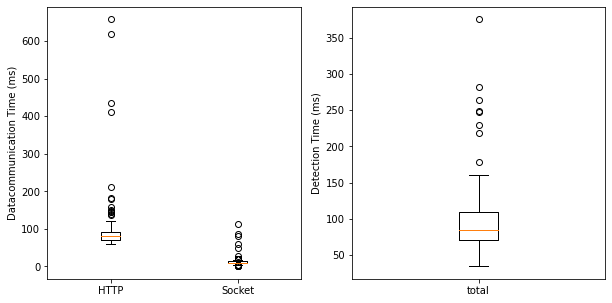

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df_http = pd.read_excel('output_http.xlsx', sheet_name='RAW', nrows=139)
df_socket = pd.read_excel('output_socket.xlsx', sheet_name='RAW', nrows=139)

http_data_A = df_http['http time data']
http_data_B = df_http['detection time data']

socket_data_A = df_socket['socket time data']
socket_data_B = df_socket['detection time data']

detection_time = socket_data_B + http_data_B

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.boxplot([http_data_A, socket_data_A])
ax1.set_xticklabels(['HTTP', 'Socket'])
ax1.set_ylabel('Datacommunication Time (ms)')

ax2.boxplot([detection_time])
ax2.set_xticklabels(['total'])
ax2.set_ylabel('Detection Time (ms)')

plt.show()


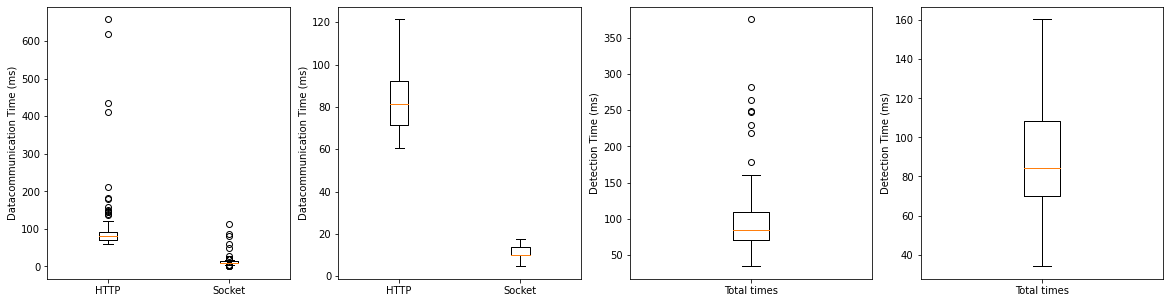

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df_http = pd.read_excel('output_http.xlsx', sheet_name='RAW', nrows=139)
df_socket = pd.read_excel('output_socket.xlsx', sheet_name='RAW', nrows=139)

http_data_A = df_http['http time data']
http_data_B = df_http['detection time data']

socket_data_A = df_socket['socket time data']
socket_data_B = df_socket['detection time data']

detection_time = socket_data_B + http_data_B

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 5))

ax1.boxplot([http_data_A, socket_data_A], showfliers=True)
ax1.set_xticklabels(['HTTP', 'Socket'])
ax1.set_ylabel('Datacommunication Time (ms)')

ax2.boxplot([http_data_A, socket_data_A], showfliers=False)
ax2.set_xticklabels(['HTTP', 'Socket'])
ax2.set_ylabel('Datacommunication Time (ms)')

ax3.boxplot([detection_time], showfliers=True)
ax3.set_xticklabels(['Total times'])
ax3.set_ylabel('Detection Time (ms)')

ax4.boxplot([detection_time], showfliers=False)
ax4.set_xticklabels(['Total times'])
ax4.set_ylabel('Detection Time (ms)')

plt.show()


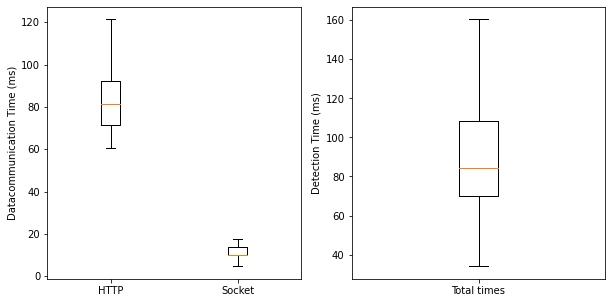

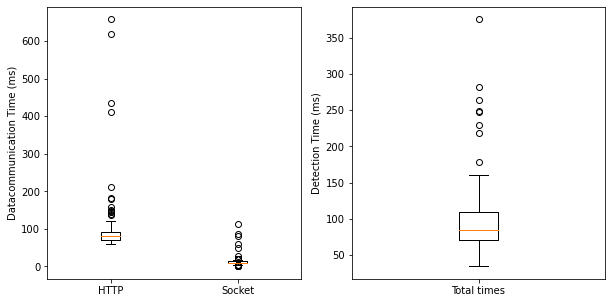

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df_http = pd.read_excel('output_http.xlsx', sheet_name='RAW', nrows=139)
df_socket = pd.read_excel('output_socket.xlsx', sheet_name='RAW', nrows=139)

http_data_A = df_http['http time data']
http_data_B = df_http['detection time data']

socket_data_A = df_socket['socket time data']
socket_data_B = df_socket['detection time data']

detection_time = socket_data_B + http_data_B

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.boxplot([http_data_A, socket_data_A], showfliers=False)
ax1.set_xticklabels(['HTTP', 'Socket'])
ax1.set_ylabel('Datacommunication Time (ms)')

ax2.boxplot([detection_time], showfliers=False)
ax2.set_xticklabels(['Total times'])
ax2.set_ylabel('Detection Time (ms)')

fig.patch.set_facecolor('white')
plt.savefig('boxplots_without_outliers.png')
plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.boxplot([http_data_A, socket_data_A], showfliers=True)
ax1.set_xticklabels(['HTTP', 'Socket'])
ax1.set_ylabel('Datacommunication Time (ms)')

ax2.boxplot([detection_time], showfliers=True)
ax2.set_xticklabels(['Total times'])
ax2.set_ylabel('Detection Time (ms)')

fig.patch.set_facecolor('white')
plt.savefig('boxplots_with_outliers.png')
plt.show()

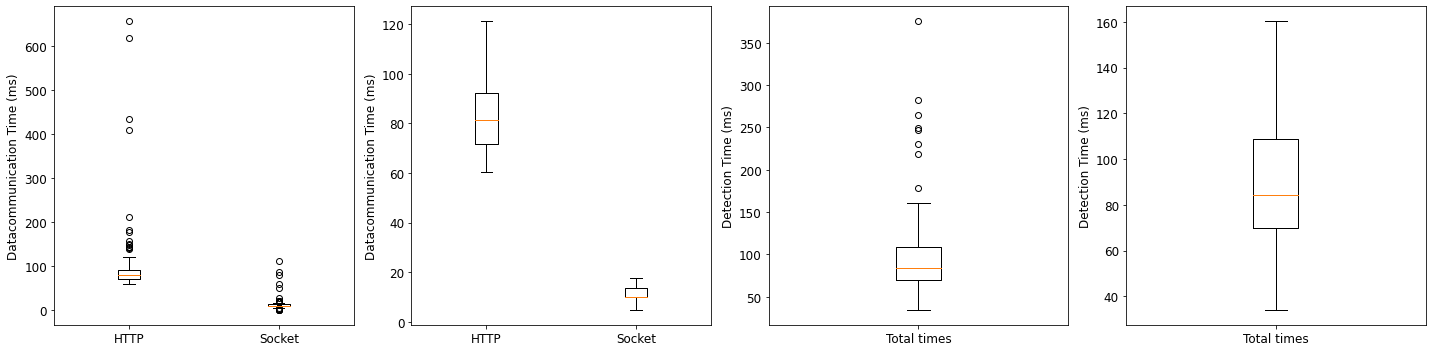

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df_http = pd.read_excel('output_http.xlsx', sheet_name='RAW', nrows=139)
df_socket = pd.read_excel('output_socket.xlsx', sheet_name='RAW', nrows=139)

http_data_A = df_http['http time data']
http_data_B = df_http['detection time data']

socket_data_A = df_socket['socket time data']
socket_data_B = df_socket['detection time data']

detection_time = socket_data_B + http_data_B

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 5))

ax1.boxplot([http_data_A, socket_data_A], showfliers=True)
ax1.set_xticklabels(['HTTP', 'Socket'], fontsize=12)
ax1.set_ylabel('Datacommunication Time (ms)', fontsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax2.boxplot([http_data_A, socket_data_A], showfliers=False)
ax2.set_xticklabels(['HTTP', 'Socket'], fontsize=12)
ax2.set_ylabel('Datacommunication Time (ms)', fontsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax3.boxplot([detection_time], showfliers=True)
ax3.set_xticklabels(['Total times'], fontsize=12)
ax3.set_ylabel('Detection Time (ms)', fontsize=12)
ax3.tick_params(axis='y', labelsize=12)

ax4.boxplot([detection_time], showfliers=False)
ax4.set_xticklabels(['Total times'], fontsize=12)
ax4.set_ylabel('Detection Time (ms)', fontsize=12)
ax4.tick_params(axis='y', labelsize=12)

for ax in [ax1, ax2, ax3, ax4]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(12)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig('boxplots.png', dpi=300)
plt.show()


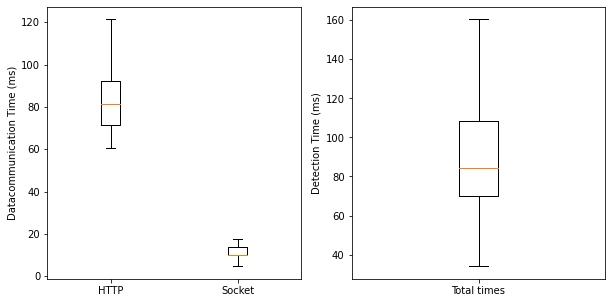

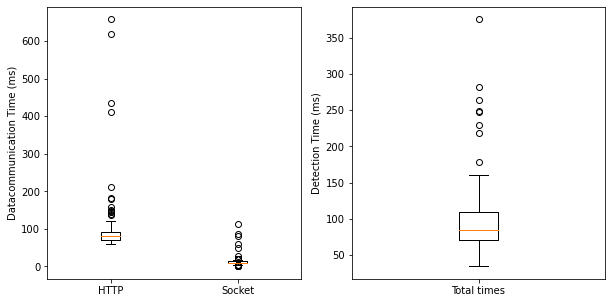

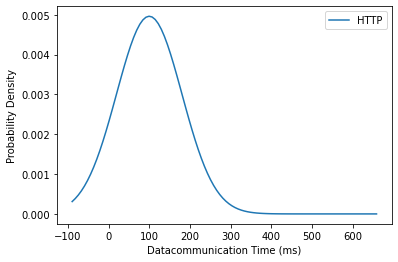

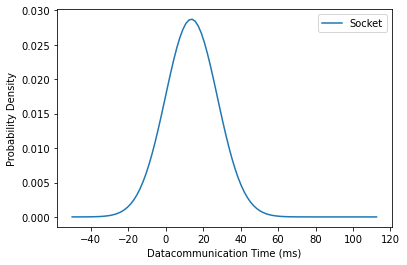

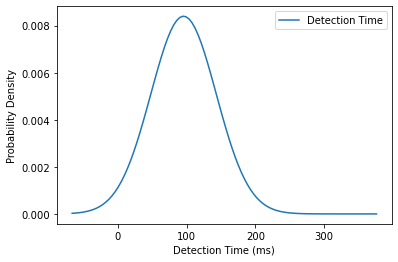

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

df_http = pd.read_excel('output_http.xlsx', sheet_name='RAW', nrows=139)
df_socket = pd.read_excel('output_socket.xlsx', sheet_name='RAW', nrows=139)

http_data_A = df_http['http time data']
http_data_B = df_http['detection time data']

socket_data_A = df_socket['socket time data']
socket_data_B = df_socket['detection time data']

detection_time = socket_data_B + http_data_B

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.boxplot([http_data_A, socket_data_A], showfliers=False)
ax1.set_xticklabels(['HTTP', 'Socket'])
ax1.set_ylabel('Datacommunication Time (ms)')

ax2.boxplot([detection_time], showfliers=False)
ax2.set_xticklabels(['Total times'])
ax2.set_ylabel('Detection Time (ms)')

fig.patch.set_facecolor('white')
plt.savefig('boxplots_without_outliers.png')
plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.boxplot([http_data_A, socket_data_A], showfliers=True)
ax1.set_xticklabels(['HTTP', 'Socket'])
ax1.set_ylabel('Datacommunication Time (ms)')

ax2.boxplot([detection_time], showfliers=True)
ax2.set_xticklabels(['Total times'])
ax2.set_ylabel('Detection Time (ms)')

fig.patch.set_facecolor('white')
plt.savefig('boxplots_with_outliers.png')
plt.show()

# Calculate mean and standard deviation
http_mean = np.mean(http_data_A)
http_std = np.std(http_data_A)

socket_mean = np.mean(socket_data_A)
socket_std = np.std(socket_data_A)

detection_mean = np.mean(detection_time)
detection_std = np.std(detection_time)


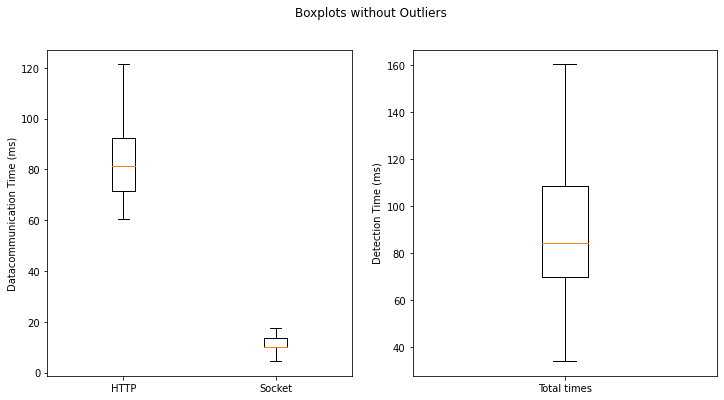

HTTP timing: 99.77 ± 80.37 ms
Socket timing: 13.67 ± 13.89 ms


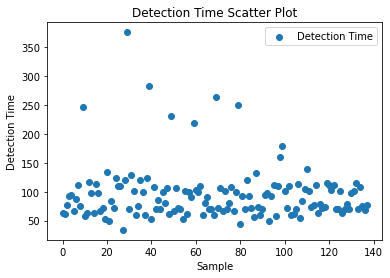

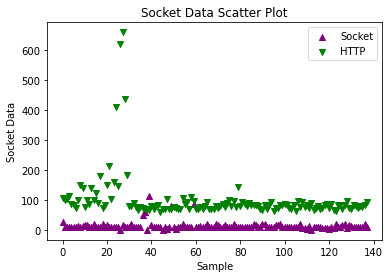

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

df_http = pd.read_excel('output_http.xlsx', sheet_name='RAW', nrows=139)
df_socket = pd.read_excel('output_socket.xlsx', sheet_name='RAW', nrows=139)

http_data_A = df_http['http time data']
http_data_B = df_http['detection time data']

socket_data_A = df_socket['socket time data']
socket_data_B = df_socket['detection time data']

detection_time = socket_data_B + http_data_B

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.boxplot([http_data_A, socket_data_A], showfliers=False, labels=['HTTP', 'Socket'])
ax1.set_ylabel('Datacommunication Time (ms)')

ax2.boxplot([detection_time], showfliers=False, labels=['Total times'])
ax2.set_ylabel('Detection Time (ms)')

fig.patch.set_facecolor('white')
fig.suptitle('Boxplots without Outliers')
plt.savefig('boxplots_without_outliers.png')
plt.show()

# Calculate deviation from the mean
http_data_A_dev = np.mean(http_data_A)
socket_data_A_dev = np.mean(socket_data_A)
detection_time_dev = np.mean(detection_time)

# Print accuracy of the data
print(f'HTTP timing: {np.mean(http_data_A):.2f} ± {np.std(http_data_A):.2f} ms')
print(f'Socket timing: {np.mean(socket_data_A):.2f} ± {np.std(socket_data_A):.2f} ms')




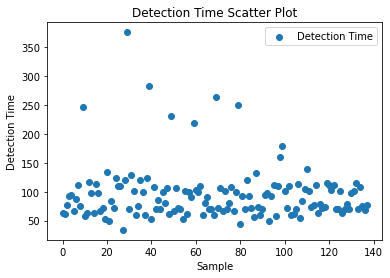

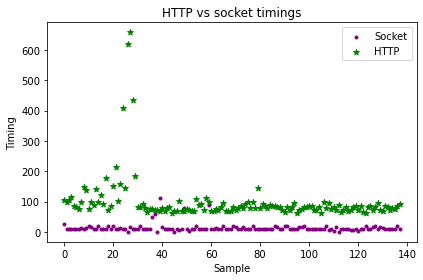

In [27]:
#geen normaal, long tail functie opzoeken timings ---- scatterplot maken!  http en socket samen tonen!
# scatter plot for detection time
plt.scatter(range(len(detection_time)), detection_time, label='Detection Time')

fig.patch.set_facecolor('white')
plt.title('Detection Time Scatter Plot')
plt.xlabel('Sample')
plt.ylabel('Detection Time')
plt.legend()

plt.savefig('Scatterplot_timings_detection.png')
plt.show()

# scatter plot for socket_data_A and socket_data_B
plt.scatter(range(len(socket_data_A)), socket_data_A, label='Socket', color='purple', marker='.')
plt.scatter(range(len(http_data_A)), http_data_A, label='HTTP', color='green', marker='*')

plt.title('HTTP vs socket timings')
plt.xlabel('Sample')
plt.ylabel('Timing')
plt.legend()

fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig('Scatterplots_http_socket.png')
plt.show()
